In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from os import listdir
from os.path import isfile, join
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import time
from scipy.interpolate import LSQUnivariateSpline

In [31]:
random.seed(42)
torch.manual_seed(42)

In [32]:
#Uses same model as in Stocks Transformer 1

In [33]:
class Embedding(nn.Module):
    def __init__(self, input_size, embed_dim): 
        super(Embedding, self).__init__()
        
        self.embed_dim = embed_dim
        self.input_size = input_size
        
    def forward(self, x):
        batch_size = x.size(0) 
        C = torch.randn((batch_size, self.input_size, self.embed_dim)) 
        for i in range(len(x)):
            for j in range(len(x[i])):
                C[i][j]*=x[i][j]
        return C 

In [34]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_seq_len, embed_model_dim):
        super(PositionalEmbedding, self).__init__()
        
        self.embed_dim = embed_model_dim
        
        pe = torch.zeros(max_seq_len, self.embed_dim) 
        
        for pos in range(max_seq_len):
            for i in range(0, self.embed_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2*i)/self.embed_dim)))
                pe[pos, i+1] = math.cos(pos / (10000 ** ((2 * (i + 1))/self.embed_dim)))
        
        pe = pe.unsqueeze(0) 
        self.register_buffer('pe', pe) 
        
    def forward(self, x):
        x *= math.sqrt(self.embed_dim) 
        seq_len = x.size(1)
        x += torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False) 
        return x

In [35]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        super(MultiHeadAttention, self).__init__()
        
        self.embed_dim = embed_dim
        
        self.n_heads = n_heads
        self.single_head_dim = int(self.embed_dim / self.n_heads) 
        
        self.query_matrix = nn.Linear(self.single_head_dim , self.single_head_dim ,bias=False) 
        self.key_matrix = nn.Linear(self.single_head_dim  , self.single_head_dim, bias=False) 
        self.value_matrix = nn.Linear(self.single_head_dim ,self.single_head_dim , bias=False) 
        
        self.out = nn.Linear(self.n_heads*self.single_head_dim ,self.embed_dim) 
        
    def forward(self, key, query, value, mask=None):
        batch_size = key.size(0)
        seq_length = key.size(1)
        seq_length_query = query.size(1)
        
        key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim) 
        query = query.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim)
        value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim)

        k = self.key_matrix(key).transpose(1, 2) 
        q = self.query_matrix(query).transpose(1, 2)   
        v = self.value_matrix(value).transpose(1, 2) 

        k_adjusted = k.transpose(-1, -2) 

        product = torch.matmul(q, k_adjusted)

        if mask is not None:
            product = product.masked_fill(mask == 0, float("-1e20")) 

        product = product / math.sqrt(self.single_head_dim) 

        scores = F.softmax(product, dim=-1)
        scores = torch.matmul(scores, v) 
        concat = scores.transpose(1,2).contiguous().view(batch_size, seq_length_query, self.single_head_dim*self.n_heads) 

        output = self.out(concat)

        return output


In [36]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, dropout_value, expansion_factor = 4, n_heads = 8):
        super(TransformerBlock, self).__init__()
        
        self.attention = MultiHeadAttention(embed_dim, n_heads)
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        self.feed_forward = nn.Sequential(
                        nn.Linear(embed_dim, expansion_factor * embed_dim),
                        nn.ReLU(),
                        nn.Linear(expansion_factor * embed_dim, embed_dim)
        )
        
        self.dropout1 = nn.Dropout(dropout_value)
        self.dropout2 = nn.Dropout(dropout_value)
    
    def forward(self, key, query, value):
        attention_out = self.attention(key, query, value)
        attention_residual_out = attention_out + query
        norm1_out = self.dropout1(self.norm1(attention_out)) 
        
        feed_fwd_out = self.feed_forward(norm1_out)
        feed_fwd_residual_out = feed_fwd_out + norm1_out
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out))
        
        return norm2_out

In [37]:
class TransformerEncoder(nn.Module):
    def __init__(self, seq_len, input_size, embed_dim, num_layers=2, expansion_factor=4, n_heads=8): 
        super(TransformerEncoder, self).__init__()
        
        self.embedding_layer = Embedding(input_size, embed_dim) 
        self.positional_encoder = PositionalEmbedding(seq_len, embed_dim)
        
        self.layers = nn.ModuleList([TransformerBlock(embed_dim, dropout_value, expansion_factor, n_heads) for i in range(num_layers)])
        
    def forward(self, x):
        embed_out = self.embedding_layer(x)
        out = self.positional_encoder(embed_out)
        for layer in self.layers:
            out = layer(out, out, out)

        return out

In [38]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, dropout_value, expansion_factor=4, n_heads=8):
        super(DecoderBlock, self).__init__()
        
        self.attention = MultiHeadAttention(embed_dim, n_heads=8)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout_value)
        self.transformer_block = TransformerBlock(embed_dim, dropout_value, expansion_factor, n_heads)
        
    def forward(self, key, x, value, mask):
        attention = self.attention(x, x, x, mask=mask)
        x = self.dropout(self.norm(attention + x))
        out = self.transformer_block(key, x, value)
        
        return out

In [39]:
class TransformerDecoder(nn.Module):
    def __init__(self, decoder_input_size, embed_dim, seq_len, target_output_size, dropout_value, num_layers=2, expansion_factor=4, n_heads=8): ###batch size after target output
        super(TransformerDecoder, self).__init__()
        
        self.embedding = Embedding(decoder_input_size, embed_dim) 
        self.position_embedding = PositionalEmbedding(seq_len, embed_dim)
        self.fst_attention = DecoderBlock(embed_dim, dropout_value, expansion_factor=4, n_heads=8)
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, dropout_value, expansion_factor=4, n_heads=8) 
                for _ in range(num_layers)
            ]

        )
        self.fc1_out = nn.Linear(embed_dim, target_output_size)
        self.fc2_out = nn.Linear(decoder_input_size, target_output_size)
        self.dropout = nn.Dropout(dropout_value)
        
    def forward(self, x, enc_out, mask):
        x = self.embedding(x) 
        x = self.position_embedding(x)
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask=None)
        
        out = self.fc1_out(x)
        out = torch.squeeze(out)
        out = self.fc2_out(out)
        out = torch.squeeze(out)
        return out

In [40]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, input_size, decoder_input_size, target_output_size, seq_length,num_layers=2, dropout_value=0.2, expansion_factor=4, n_heads=8): ###batch_size, after target output
        super(Transformer, self).__init__()
        
        self.decoder_input_size = decoder_input_size
        
        self.encoder = TransformerEncoder(seq_length, input_size, embed_dim, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads) ###batch_size=batch_size, after embed dim
        self.decoder = TransformerDecoder(decoder_input_size, embed_dim, seq_length, target_output_size, dropout_value, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads) ###batch_size=batch_size, after target output
        
    def make_trg_mask(self, trg):
        batch_size, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(batch_size, 1, trg_len, trg_len) 
        return trg_mask
    
    def decode(self, src, trg):
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size, seq_len = src.shape[0], src.shape[1]
        
        out = trg
        for i in range(seq_len):
            out = self.decoder(out, enc_out, trg_mask)
            
            out = out[:, -1, :]
            
            out = out.argmax(-1)
            out_labels.append(out.item())
            out = torch.unsqueeze(out, axis=0)
            
        return out_labels
    
    def forward(self, src, trg):
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src) 
        
        outputs = self.decoder(trg, enc_out, trg_mask) 
        return outputs

In [41]:
input_size = 10
decoder_input_size = 9
target_output_size = 1
num_layers = 6
seq_length = 10 
batch_size = 16
dropout_value = 0.2
num_training_stocks = 4


model = Transformer(embed_dim=32, input_size=input_size, 
                    decoder_input_size=decoder_input_size, target_output_size=target_output_size, seq_length=seq_length,
                    num_layers=num_layers, dropout_value=dropout_value, expansion_factor=4, n_heads=8) ###batch_size=batch_size, after num layers

current_path = os.path.join(r'C:\Users', 'barne', 'Diss', 'Stocks', 'Code', 'Network 1')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [25]:
class CustomDataset():
    def __init__(self, inputs, labels, transform=None, target_transform=None):
        self.labels = labels
        self.inputs = inputs
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        inpt = self.inputs[idx]
        label = self.labels[idx]
        if self.transform:
            inpt = self.transform(inpt)
        if self.target_transform:
            label = self.target_transform(label)
        return inpt, label

In [28]:
#load data
mypath = os.path.join(current_path, 'Network1', 'Stocks')
stocks = [f for f in listdir(mypath) if isfile(join(mypath, f))]

Xtr, Ytr = [], []
Xval, Yval = [], []
Xte, Yte = [], []

block_size = input_size


def build_dataset(prices):
            X, Y = [], []
            if len(prices)<block_size+1:
                return [], []
            for i in range(len(prices)-block_size):
                X.append(prices[i:i+block_size])
                Y.append(prices[i+block_size])
            X = torch.tensor(X)
            Y = torch.tensor(Y)
            return X, Y

#choose which method of smoothing to use
method = 'mov'
smooth_const = 5
        
#create the datasets
all_train_prices = [0]
all_smooth_prices = [0]
for stock in stocks[1:num_training_stocks+1]:
    data = open(os.path.join(mypath, stock)).read().splitlines()[1:]


    year_lookup = {}
    for day in data:
        lst = day.split(',')
        year = int(lst[0][:4])
        closing = float(lst[4])
        if year not in year_lookup.keys():
            year_lookup[year] = [closing]
        else:
            year_lookup[year].append(closing)
    
    #build dataset
    prices = []
    train_prices = []
    validation_prices = []
    test_prices = []
    mean = 0
    std = 0
    years = list(year_lookup.keys())
    if stock == stocks[num_training_stocks]:
        for year in years:
            test_prices += year_lookup[year]
            prices += year_lookup[year]
    else:
        training_cut_off = years[math.ceil(0.75*len(years))-1]
        for year in range(years[0], training_cut_off):
            train_prices+=year_lookup[year]
            prices += year_lookup[year]

        for year in range(training_cut_off, years[-1]):
            validation_prices+=year_lookup[year]
            prices += year_lookup[year]
        
    mean = np.mean(prices)
    std = np.std(prices)
    
    train_prices = (train_prices-mean)/std
    validation_prices = (test_prices-mean)/std
    test_prices = (test_prices-mean)/std
    
    #moving average
    if method == 'mov':
        smooth_prices = [price for price in train_prices[:smooth_const-1]]
        for i in range(smooth_const, len(train_prices)+1):
            smooth_prices.append(sum(train_prices[i-smooth_const:i])/smooth_const)
        

    #exponential moving average
    if method == 'exp':
        if len(train_prices) > 0:
            smooth_prices = [train_prices[0]]
            for i in range(1, len(train_prices)):
                smooth_prices.append(smooth_const*train_prices[i]+(1-smooth_const)*smooth_prices[i-1])
            
    
    
    #adjusted moving average
    if method == 'adj':
        smooth_prices = [price for price in train_prices[:smooth_const-1]]
        for i in range(smooth_const, len(train_prices)+1):
            smooth_prices.append(sum(train_prices[i-smooth_const:i])/smooth_const)

        def bias_calc(lst):
            bias = 0
            count = 0
            for j in range(1, len(lst)):
                if (train_prices[j]-lst[j])*(train_prices[j-1]-lst[j-1]) > 0:
                    count+=1
                    bias+=count**2
                else:
                    count = 0
            return bias

        bias1 = {}
        for alpha in [i/1000 for i in range(31)]:
            bias = [bias_calc(smooth_prices), bias_calc(smooth_prices)]
            Beta = 0
            sign = 1
            end = True
            for step in [0.1, 0.01, 0.001]:
                while bias[1] <= bias[0]:
                    Beta += sign*step
                    adjusted_prices = [price for price in smooth_prices[0:math.ceil(smooth_const*1.5)]]
                    for i in range(math.ceil(smooth_const*1.5) + 1, len(smooth_prices)):
                        if abs((smooth_prices[i]-smooth_prices[i-1])/smooth_prices[i-1]) > alpha:
                            adjusted_prices.append(smooth_prices[i]+Beta*(smooth_prices[i]-smooth_prices[i-1]))
                            end = False
                        else:
                            adjusted_prices.append(smooth_prices[i])
                    bias[0] = bias[1]
                    bias[1] = bias_calc(adjusted_prices)
                    if end:
                        break
                bias[0] = bias[1]
                if end:
                    break
                sign*=-1
            bias1[alpha] = [Beta-0.001, bias[0]]

        best_bias = bias1[0.001][1]
        best_alpha = 0.001
        best_beta = 0
        for alpha in bias1.keys():
            if bias1[alpha][1] < best_bias:
                best_alpha = alpha
                best_beta = bias1[alpha][0]
                best_bias = bias1[alpha][1]

        adj_smooth_prices = [price for price in smooth_prices]
        for i in range(math.ceil(smooth_const*1.5) + 1, len(smooth_prices)):
            if abs((smooth_prices[i]-smooth_prices[i-1])/smooth_prices[i-1]) > alpha:
                adj_smooth_prices[i] += best_beta*(smooth_prices[i]-smooth_prices[i-1])
        smooth_prices = adj_smooth_prices
        
    
    

    #spline smoothing
    if method == 'spline':
        if len(train_prices) > 1:
            num_datapoints = smooth_const
            num_knots = max(0, math.floor(len(train_prices)/num_datapoints-1))
            time = np.arange(len(train_prices))

            knot_indices = np.linspace(num_datapoints, len(time) - 1-num_datapoints, num_knots).astype(int)
            knots = time[knot_indices]

            cs = LSQUnivariateSpline(time, train_prices, k=3, t=knots)
            smooth_prices = cs(time)

    Xtr += build_dataset(smooth_prices)[0]
    Ytr += build_dataset(smooth_prices)[1]
    Xval += build_dataset(validation_prices)[0]
    Yval += build_dataset(validation_prices)[1]
    Xte, Yte = build_dataset(test_prices)
    
    all_train_prices.extend(train_prices)
    all_smooth_prices.extend(smooth_prices)

training_data = CustomDataset(Xtr, Ytr)
val_data = CustomDataset(Xval, Yval)

In [13]:
#load smoothed prices into dicts to calculate bias and mse for each method
mypath = os.path.join(current_path, 'Network1', 'Stocks')
stocks = [f for f in listdir(mypath) if isfile(join(mypath, f))]

def add_to_dict(key, value, dct):
    if key in dct:
        dct[key] = np.concatenate((dct[key],value))
    else:
        dct[key] = value

all_train_prices = []

all_mov_smooth_prices = {}
all_centmov_smooth_prices = {}
all_exp_smooth_prices = {}
all_spline_smooth_prices = {}

for stock in stocks[1:num_training_stocks+1]:
    data = open(os.path.join(mypath, stock)).read().splitlines()[1:]


    year_lookup = {}
    for day in data:
        lst = day.split(',')
        year = int(lst[0][:4])
        closing = float(lst[4])
        if year not in year_lookup.keys():
            year_lookup[year] = [closing]
        else:
            year_lookup[year].append(closing)
    
    #build dataset
    prices = []
    train_prices = []
    validation_prices = []
    test_prices = []
    mean = 0
    std = 0
    years = list(year_lookup.keys())
    if stock == stocks[num_training_stocks]:
        for year in years:
            test_prices += year_lookup[year]
            prices += year_lookup[year]
    else:
        training_cut_off = years[math.ceil(0.75*len(years))-1]
        for year in range(years[0], training_cut_off):
            train_prices+=year_lookup[year]
            prices += year_lookup[year]

        for year in range(training_cut_off, years[-1]):
            validation_prices+=year_lookup[year]
            prices += year_lookup[year]
    
    #moving average
    for sc in [3, 5, 10, 20, 50]:
        smooth_const = sc
        mov_smooth_prices = [price for price in train_prices[:smooth_const-1]]
        for i in range(smooth_const, len(train_prices)+1):
            mov_smooth_prices.append(sum(train_prices[i-smooth_const:i])/smooth_const)
        add_to_dict(sc, mov_smooth_prices, all_mov_smooth_prices)
        
    #centered moving average
    for sc in [3, 5, 10, 20]:
        smooth_const = sc
        centmov_smooth_prices = [price for price in train_prices[:math.ceil(smooth_const/2)-1]]
        for i in range(math.ceil(smooth_const/2), len(train_prices)+1-math.floor(smooth_const/2)):
            centmov_smooth_prices.append(sum(train_prices[i-math.ceil(smooth_const/2):i+math.floor(smooth_const/2)])/smooth_const)
        centmov_smooth_prices.extend(train_prices[-math.floor(smooth_const/2):])
        add_to_dict(sc, centmov_smooth_prices, all_centmov_smooth_prices)  
    
    #exponential moving average
    if len(train_prices) > 0:
        for sc in [0.1, 0.15, 0.2, 0.25]:
            smooth_const = sc
            exp_smooth_prices = [train_prices[0]]
            for i in range(1, len(train_prices)):
                exp_smooth_prices.append(smooth_const*train_prices[i]+(1-smooth_const)*exp_smooth_prices[i-1])
            add_to_dict(sc, exp_smooth_prices, all_exp_smooth_prices)

    #spline smoothing
    if len(train_prices) > 1:
        for n in [5, 10, 15, 20]:
            num_datapoints = n
            num_knots = max(0, math.floor(len(train_prices)/num_datapoints-1))
            time = np.arange(len(train_prices))

            knot_indices = np.linspace(num_datapoints, len(time) - 1-num_datapoints, num_knots).astype(int)
            knots = time[knot_indices]

            cs = LSQUnivariateSpline(time, train_prices, k=3, t=knots)
            spline_smooth_prices = cs(time)
            add_to_dict(n, spline_smooth_prices, all_spline_smooth_prices)

    #all_train_prices.extend(train_prices)
    #all_smooth_prices.extend(smooth_prices)



In [14]:
#calculates bias values
def bias_calc(lst):
    bias = 0
    count = 0
    for j in range(1, len(lst)):
        if (all_train_prices[j]-lst[j])*(all_train_prices[j-1]-lst[j-1]) > 0:
            count+=1
            bias+=count**2
        else:
            count = 0
    return bias

In [16]:
#creates dict for adjusted moving average 
all_adjmov_smooth_prices = {}
Betas = {}
for key in all_mov_smooth_prices.keys():
    bias1 = {}
    for alpha in [i/1000 for i in range(21)]:
        bias = [bias_calc(all_mov_smooth_prices[key]), bias_calc(all_mov_smooth_prices[key])]
        Beta = 0
        sign = 1
        for step in [0.1, 0.01, 0.001]:
            while bias[1] <= bias[0]:
                Beta += sign*step
                adjusted_prices = [price for price in all_mov_smooth_prices[key][0:math.ceil(key*1.5)]]
                for i in range(math.ceil(key*1.5) + 1, len(list(all_mov_smooth_prices[key]))):
                    if abs(all_mov_smooth_prices[key][i]-all_mov_smooth_prices[key][i-1])/all_mov_smooth_prices[key[i-1]] > alpha:
                        adjusted_prices.append(all_mov_smooth_prices[key][i]+Beta*(all_mov_smooth_prices[key][i]-all_mov_smooth_prices[key][i-1]))
                    else:
                        adjusted_prices.append(all_mov_smooth_prices[key][i])
                bias[0] = bias[1]
                bias[1] = bias_calc(adjusted_prices)
            bias[0] = bias[1]
            sign*=-1
        if alpha not in bias1.keys():
            bias1[alpha] = [Beta-0.001, bias[0]]
        elif bias[0] < bias1[alpha][1]:
            bias1[alpha] = [Beta-0.001, bias[0]]
    
    best_bias = bias1[0.001][1]
    best_alpha = 0.001
    best_beta = 0
    for alpha in bias1.keys():
        if bias1[alpha][1] < best_bias:
            best_alpha = alpha
            best_beta = bias1[alpha][0]
        
    Betas[key] = [best_alpha, best_beta]
    smooth_const = key
    adj_smooth_prices = [price for price in all_mov_smooth_prices[key]]
    for i in range(math.ceil(key*1.5) + 1, len(list(all_mov_smooth_prices[key]))):
        if abs(all_mov_smooth_prices[key][i]-all_mov_smooth_prices[key][i-1])/all_mov_smooth_prices[key[i-1]] > alpha:
            adj_smooth_prices[i] += best_beta*(all_mov_smooth_prices[key][i]-all_mov_smooth_prices[key][i-1])
    add_to_dict(key, adj_smooth_prices, all_adjmov_smooth_prices)
print(Betas)

{3: [0.02, 0.07999999999999997], 5: [0.001, 0], 10: [0.001, 0], 20: [0.007, 8.68999999999998], 50: [0.003, 1.0819999999999985]}


mov 3


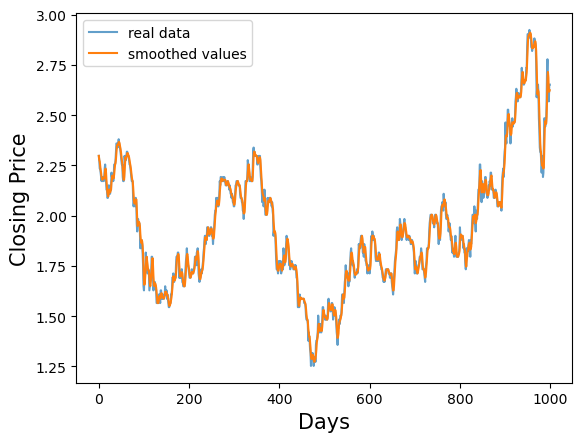

mov 5


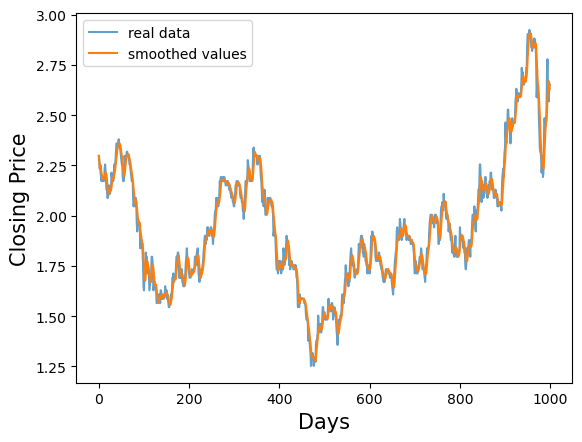

mov 10


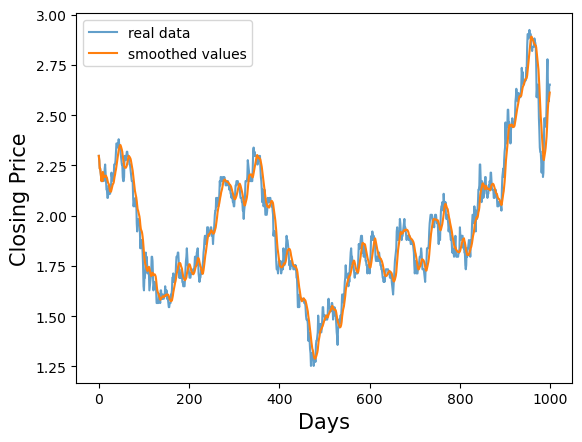

mov 20


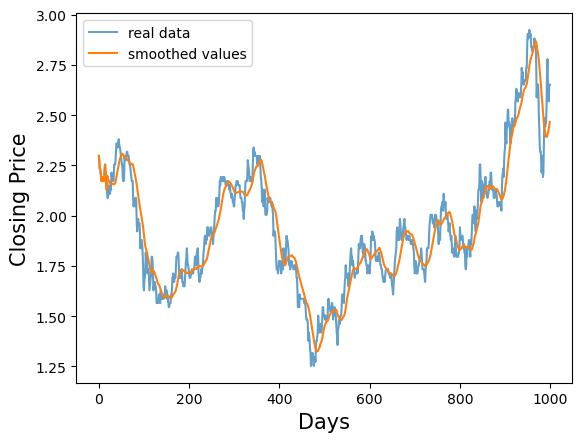

mov 50


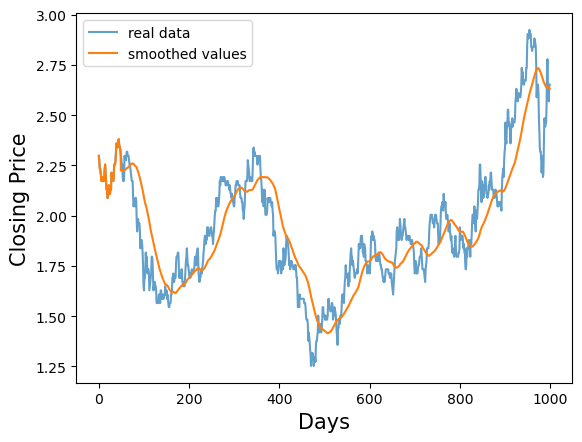

centmov 3


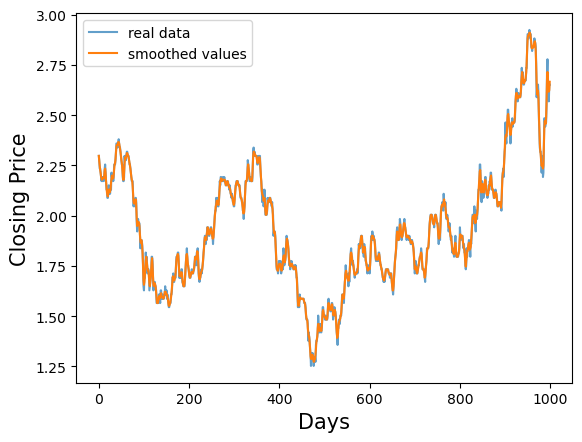

centmov 5


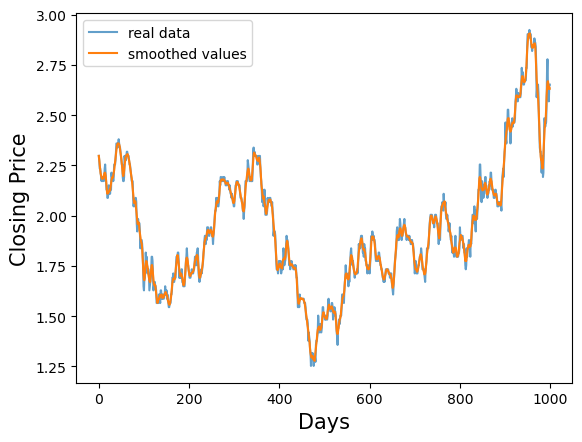

centmov 10


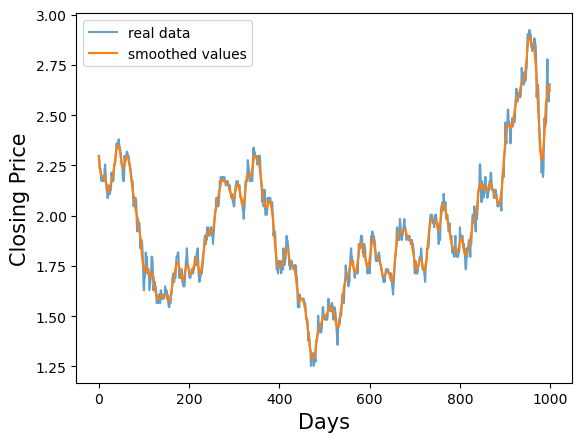

centmov 20


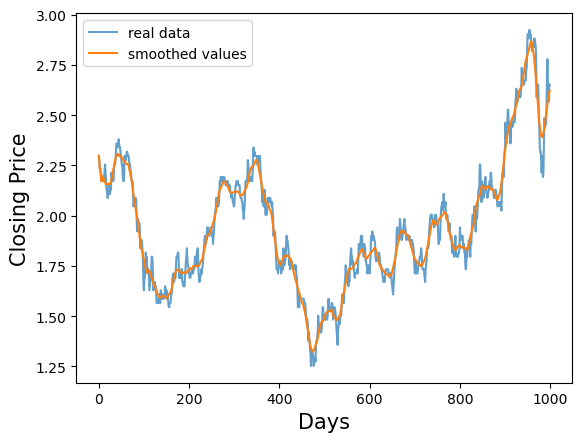

exp 0.1


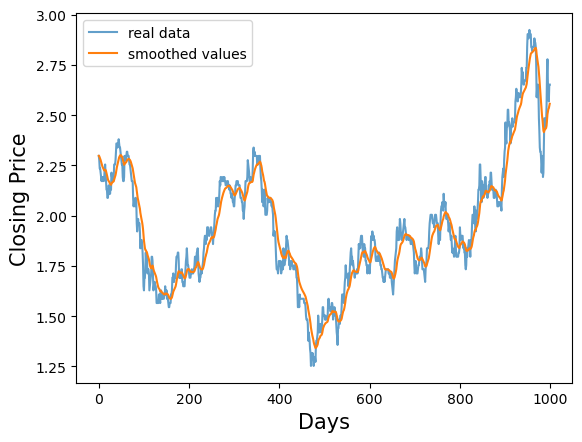

exp 0.15


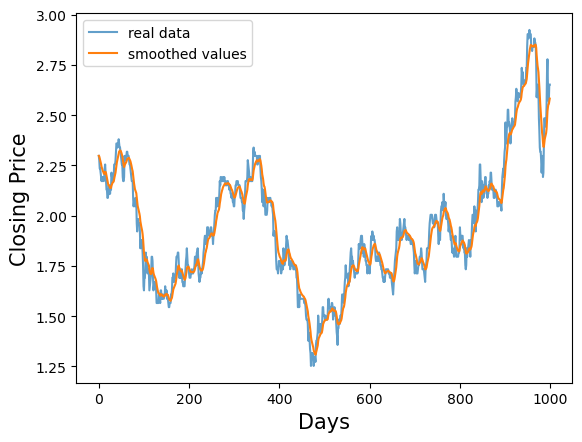

exp 0.2


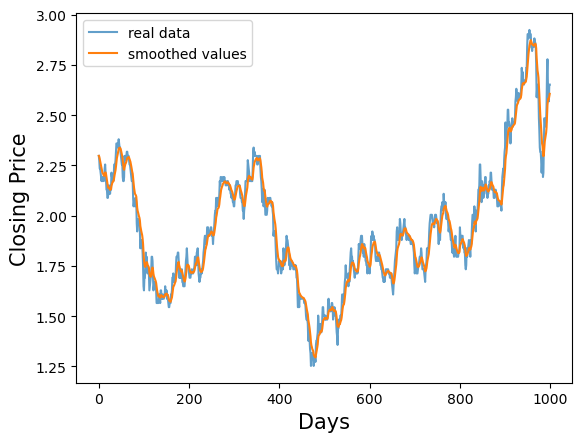

exp 0.25


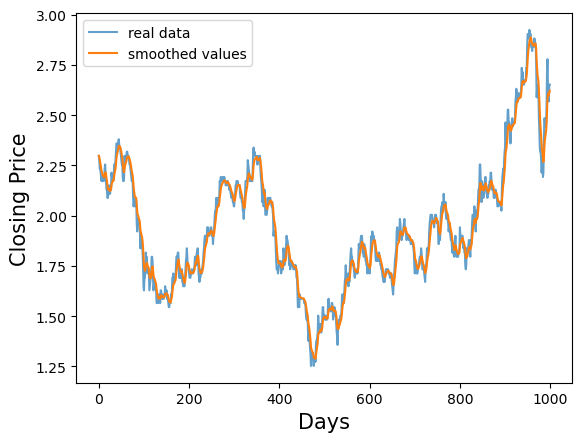

spline 5


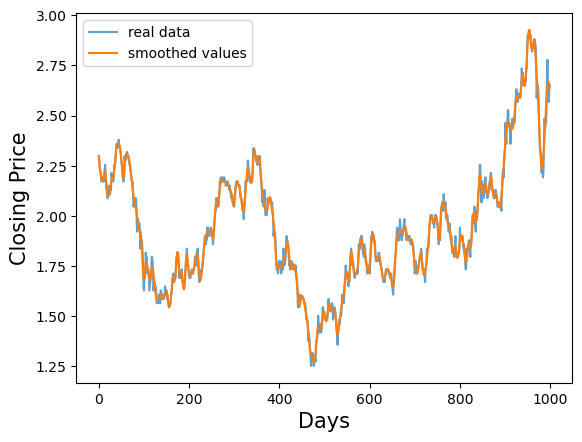

spline 10


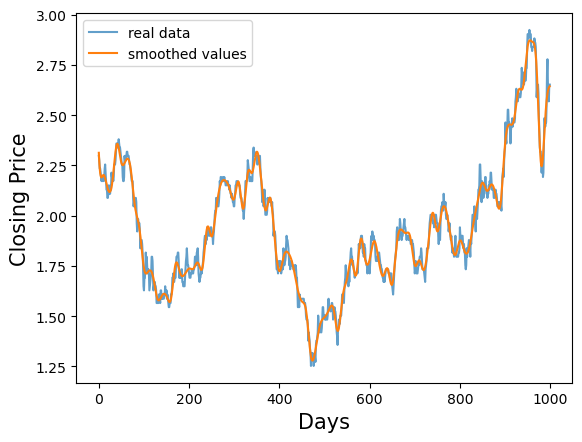

spline 15


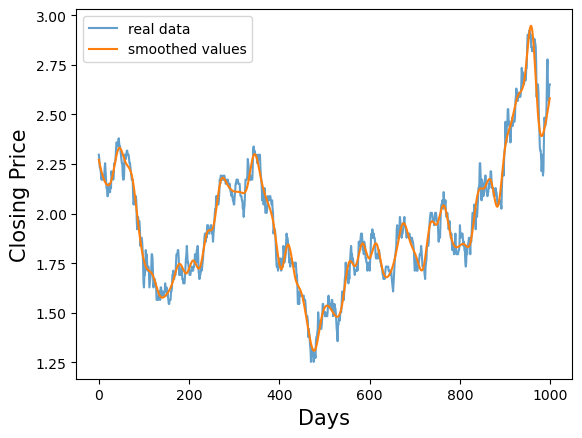

spline 20


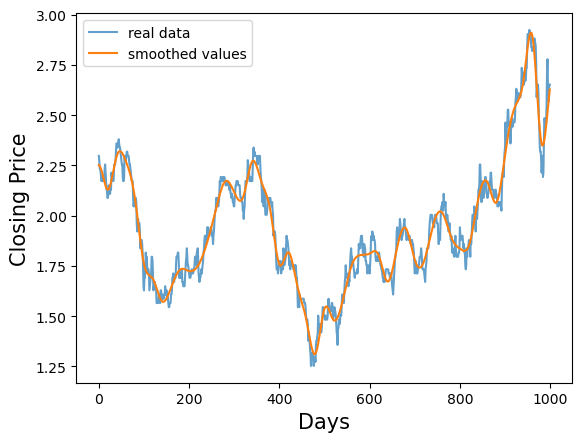

In [19]:
#plots the graph of each smoothing method
dicts = [all_mov_smooth_prices, all_centmov_smooth_prices, all_adjmov_smooth_prices, all_exp_smooth_prices, all_spline_smooth_prices]
names = ["mov", "centmov", "adjmov", "exp", "spline"]

for i in range(len(dicts)):
    smooth = dicts[i]
    for key in smooth.keys():
        print(names[i], key)
        plt.plot(all_train_prices[:1000], alpha=0.7, label='real data')
        plt.plot(smooth[key][:1000], label='smoothed values')
        plt.xlabel('Days', fontsize=15)
        plt.ylabel('Closing Price', fontsize=15)
        plt.legend()
        plt.show()

In [29]:
#calculate the MSE for each method
for i in range(len(dicts)):
    smooth = dicts[i]
    for key in smooth.keys():
        print(names[i], key)
        sum1=0
        for j in range(1000):
            sum1 += (all_train_prices[j]-smooth[key][j])**2
        sum1/=len(all_train_prices)
        print(sum1*10000)

NameError: name 'dicts' is not defined

In [30]:
#calculate the bias values for each method
for i in range(len(dicts)):
    smooth = dicts[i]
    for key in smooth.keys():
        print(names[i], key)
        print(bias_calc(smooth[key]))

NameError: name 'dicts' is not defined

In [13]:
trainloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [14]:
epochs = 1500
f=0
train_losses, val_losses = [], []
for e in range(epochs):
    if e%50 == 1:
        state_dict = torch.load('smoothcheckpoint' + str(f) + '.pth')
        model.load_state_dict(state_dict)
        f+=1
    start_time = time.time()
    tot_train_loss = 0
    model.train()
    for x, y in trainloader:
        if len(y) != batch_size:
            continue
        trg = x[:, 1:]
        optimizer.zero_grad()

        outputs = model(x, trg)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        tot_train_loss += loss.item()

    else:
        tot_val_loss = 0
        with torch.no_grad():
            model.eval()
            for x, y in valloader:
                if len(y) != batch_size:
                    continue
                trg = x[:, 1:]
                outputs = model(x, trg)
                loss = criterion(outputs, y)
                tot_val_loss += loss.item()#

        train_loss = tot_train_loss / len(trainloader.dataset)
        val_loss = tot_val_loss / len(valloader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(val_loss), 
              "Time taken: {:.3f}..".format(time.time()-start_time))
        
    if e%10 == 0:
        torch.save(model.state_dict(), 'smoothcheckpoint' + str(f) + '.pth')

Epoch: 1/1500..  Training Loss: 42.523..  Test Loss: 60.084..  Time taken: 59.042..
Epoch: 2/1500..  Training Loss: 29.714..  Test Loss: 38.077..  Time taken: 59.582..
Epoch: 3/1500..  Training Loss: 27.421..  Test Loss: 34.925..  Time taken: 59.432..
Epoch: 4/1500..  Training Loss: 27.398..  Test Loss: 34.868..  Time taken: 61.841..
Epoch: 5/1500..  Training Loss: 26.511..  Test Loss: 33.285..  Time taken: 60.784..
Epoch: 6/1500..  Training Loss: 23.564..  Test Loss: 25.345..  Time taken: 59.820..
Epoch: 7/1500..  Training Loss: 19.914..  Test Loss: 22.498..  Time taken: 61.722..
Epoch: 8/1500..  Training Loss: 17.351..  Test Loss: 19.375..  Time taken: 60.222..
Epoch: 9/1500..  Training Loss: 14.954..  Test Loss: 14.948..  Time taken: 59.972..
Epoch: 10/1500..  Training Loss: 12.471..  Test Loss: 11.876..  Time taken: 60.422..
Epoch: 11/1500..  Training Loss: 10.209..  Test Loss: 9.344..  Time taken: 60.530..
Epoch: 12/1500..  Training Loss: 7.827..  Test Loss: 6.058..  Time taken: 6

Epoch: 100/1500..  Training Loss: 0.709..  Test Loss: 1.728..  Time taken: 81.384..
Epoch: 101/1500..  Training Loss: 0.710..  Test Loss: 1.168..  Time taken: 81.230..
Epoch: 102/1500..  Training Loss: 0.723..  Test Loss: 1.432..  Time taken: 83.031..
Epoch: 103/1500..  Training Loss: 0.720..  Test Loss: 1.421..  Time taken: 83.543..
Epoch: 104/1500..  Training Loss: 0.726..  Test Loss: 1.567..  Time taken: 82.184..
Epoch: 105/1500..  Training Loss: 0.725..  Test Loss: 1.354..  Time taken: 80.145..
Epoch: 106/1500..  Training Loss: 0.785..  Test Loss: 1.783..  Time taken: 80.451..
Epoch: 107/1500..  Training Loss: 0.756..  Test Loss: 1.121..  Time taken: 83.181..
Epoch: 108/1500..  Training Loss: 0.711..  Test Loss: 1.320..  Time taken: 81.573..
Epoch: 109/1500..  Training Loss: 0.705..  Test Loss: 1.041..  Time taken: 79.771..
Epoch: 110/1500..  Training Loss: 0.703..  Test Loss: 1.614..  Time taken: 60.145..
Epoch: 111/1500..  Training Loss: 0.701..  Test Loss: 1.449..  Time taken: 6

Epoch: 198/1500..  Training Loss: 0.674..  Test Loss: 1.102..  Time taken: 79.481..
Epoch: 199/1500..  Training Loss: 0.626..  Test Loss: 1.067..  Time taken: 79.921..
Epoch: 200/1500..  Training Loss: 0.600..  Test Loss: 0.975..  Time taken: 79.587..
Epoch: 201/1500..  Training Loss: 0.583..  Test Loss: 0.979..  Time taken: 79.525..
Epoch: 202/1500..  Training Loss: 0.606..  Test Loss: 0.902..  Time taken: 79.769..
Epoch: 203/1500..  Training Loss: 0.602..  Test Loss: 1.314..  Time taken: 81.148..
Epoch: 204/1500..  Training Loss: 0.665..  Test Loss: 0.862..  Time taken: 91.734..
Epoch: 205/1500..  Training Loss: 0.565..  Test Loss: 1.161..  Time taken: 87.954..
Epoch: 206/1500..  Training Loss: 0.598..  Test Loss: 1.112..  Time taken: 83.022..
Epoch: 207/1500..  Training Loss: 0.573..  Test Loss: 0.858..  Time taken: 80.440..
Epoch: 208/1500..  Training Loss: 0.616..  Test Loss: 1.270..  Time taken: 80.195..
Epoch: 209/1500..  Training Loss: 0.597..  Test Loss: 1.251..  Time taken: 9

Epoch: 296/1500..  Training Loss: 0.529..  Test Loss: 0.842..  Time taken: 81.569..
Epoch: 297/1500..  Training Loss: 0.531..  Test Loss: 0.766..  Time taken: 79.910..
Epoch: 298/1500..  Training Loss: 0.583..  Test Loss: 0.814..  Time taken: 83.583..
Epoch: 299/1500..  Training Loss: 0.565..  Test Loss: 0.709..  Time taken: 84.234..
Epoch: 300/1500..  Training Loss: 0.537..  Test Loss: 0.816..  Time taken: 86.144..
Epoch: 301/1500..  Training Loss: 0.551..  Test Loss: 0.944..  Time taken: 86.264..
Epoch: 302/1500..  Training Loss: 0.548..  Test Loss: 0.876..  Time taken: 84.737..
Epoch: 303/1500..  Training Loss: 0.541..  Test Loss: 0.913..  Time taken: 84.708..
Epoch: 304/1500..  Training Loss: 0.547..  Test Loss: 0.841..  Time taken: 87.093..
Epoch: 305/1500..  Training Loss: 0.546..  Test Loss: 0.995..  Time taken: 89.750..
Epoch: 306/1500..  Training Loss: 0.536..  Test Loss: 1.034..  Time taken: 84.689..
Epoch: 307/1500..  Training Loss: 0.547..  Test Loss: 0.975..  Time taken: 8

Epoch: 394/1500..  Training Loss: 0.516..  Test Loss: 0.698..  Time taken: 65.138..
Epoch: 395/1500..  Training Loss: 0.508..  Test Loss: 0.697..  Time taken: 65.779..
Epoch: 396/1500..  Training Loss: 0.508..  Test Loss: 0.776..  Time taken: 65.071..
Epoch: 397/1500..  Training Loss: 0.514..  Test Loss: 0.732..  Time taken: 65.499..
Epoch: 398/1500..  Training Loss: 0.501..  Test Loss: 0.767..  Time taken: 65.335..
Epoch: 399/1500..  Training Loss: 0.511..  Test Loss: 0.778..  Time taken: 65.684..
Epoch: 400/1500..  Training Loss: 0.500..  Test Loss: 0.753..  Time taken: 65.347..
Epoch: 401/1500..  Training Loss: 0.787..  Test Loss: 0.877..  Time taken: 65.753..
Epoch: 402/1500..  Training Loss: 0.576..  Test Loss: 0.759..  Time taken: 65.385..
Epoch: 403/1500..  Training Loss: 0.545..  Test Loss: 0.782..  Time taken: 65.392..
Epoch: 404/1500..  Training Loss: 0.532..  Test Loss: 0.761..  Time taken: 65.640..
Epoch: 405/1500..  Training Loss: 0.512..  Test Loss: 0.762..  Time taken: 6

Epoch: 492/1500..  Training Loss: 0.504..  Test Loss: 0.696..  Time taken: 60.207..
Epoch: 493/1500..  Training Loss: 0.471..  Test Loss: 0.709..  Time taken: 61.826..
Epoch: 494/1500..  Training Loss: 0.488..  Test Loss: 0.801..  Time taken: 63.099..
Epoch: 495/1500..  Training Loss: 0.483..  Test Loss: 0.750..  Time taken: 61.897..
Epoch: 496/1500..  Training Loss: 0.488..  Test Loss: 0.664..  Time taken: 61.179..
Epoch: 497/1500..  Training Loss: 0.480..  Test Loss: 0.806..  Time taken: 60.860..
Epoch: 498/1500..  Training Loss: 0.460..  Test Loss: 0.697..  Time taken: 61.253..
Epoch: 499/1500..  Training Loss: 0.482..  Test Loss: 0.715..  Time taken: 60.780..
Epoch: 500/1500..  Training Loss: 0.487..  Test Loss: 0.741..  Time taken: 60.253..
Epoch: 501/1500..  Training Loss: 0.538..  Test Loss: 0.674..  Time taken: 60.256..
Epoch: 502/1500..  Training Loss: 0.499..  Test Loss: 0.638..  Time taken: 61.798..
Epoch: 503/1500..  Training Loss: 0.490..  Test Loss: 0.723..  Time taken: 6

Epoch: 590/1500..  Training Loss: 0.494..  Test Loss: 0.691..  Time taken: 56.088..
Epoch: 591/1500..  Training Loss: 0.472..  Test Loss: 0.899..  Time taken: 55.912..
Epoch: 592/1500..  Training Loss: 0.465..  Test Loss: 0.647..  Time taken: 56.017..
Epoch: 593/1500..  Training Loss: 0.460..  Test Loss: 0.662..  Time taken: 55.833..
Epoch: 594/1500..  Training Loss: 0.457..  Test Loss: 0.776..  Time taken: 56.127..
Epoch: 595/1500..  Training Loss: 0.454..  Test Loss: 0.784..  Time taken: 56.264..
Epoch: 596/1500..  Training Loss: 0.481..  Test Loss: 0.687..  Time taken: 55.731..
Epoch: 597/1500..  Training Loss: 0.463..  Test Loss: 0.800..  Time taken: 55.883..
Epoch: 598/1500..  Training Loss: 0.487..  Test Loss: 0.807..  Time taken: 55.780..
Epoch: 599/1500..  Training Loss: 0.477..  Test Loss: 0.664..  Time taken: 56.209..
Epoch: 600/1500..  Training Loss: 0.476..  Test Loss: 0.740..  Time taken: 56.181..
Epoch: 601/1500..  Training Loss: 0.472..  Test Loss: 0.838..  Time taken: 5

Epoch: 688/1500..  Training Loss: 0.460..  Test Loss: 0.895..  Time taken: 56.277..
Epoch: 689/1500..  Training Loss: 0.460..  Test Loss: 0.763..  Time taken: 56.217..
Epoch: 690/1500..  Training Loss: 0.472..  Test Loss: 0.785..  Time taken: 56.266..
Epoch: 691/1500..  Training Loss: 0.460..  Test Loss: 1.166..  Time taken: 56.204..
Epoch: 692/1500..  Training Loss: 0.463..  Test Loss: 0.794..  Time taken: 56.304..
Epoch: 693/1500..  Training Loss: 0.453..  Test Loss: 0.842..  Time taken: 56.203..
Epoch: 694/1500..  Training Loss: 0.460..  Test Loss: 0.945..  Time taken: 56.238..
Epoch: 695/1500..  Training Loss: 0.471..  Test Loss: 0.833..  Time taken: 56.410..
Epoch: 696/1500..  Training Loss: 0.488..  Test Loss: 0.722..  Time taken: 56.373..
Epoch: 697/1500..  Training Loss: 0.467..  Test Loss: 0.742..  Time taken: 56.872..
Epoch: 698/1500..  Training Loss: 0.449..  Test Loss: 0.797..  Time taken: 56.280..
Epoch: 699/1500..  Training Loss: 0.458..  Test Loss: 0.885..  Time taken: 5

Epoch: 786/1500..  Training Loss: 0.467..  Test Loss: 0.791..  Time taken: 58.261..
Epoch: 787/1500..  Training Loss: 0.444..  Test Loss: 0.946..  Time taken: 57.982..
Epoch: 788/1500..  Training Loss: 0.443..  Test Loss: 0.884..  Time taken: 58.126..
Epoch: 789/1500..  Training Loss: 0.447..  Test Loss: 1.062..  Time taken: 57.977..
Epoch: 790/1500..  Training Loss: 0.458..  Test Loss: 1.255..  Time taken: 57.928..
Epoch: 791/1500..  Training Loss: 0.442..  Test Loss: 0.964..  Time taken: 58.079..
Epoch: 792/1500..  Training Loss: 0.439..  Test Loss: 1.024..  Time taken: 57.914..
Epoch: 793/1500..  Training Loss: 0.427..  Test Loss: 0.837..  Time taken: 58.257..
Epoch: 794/1500..  Training Loss: 0.437..  Test Loss: 1.190..  Time taken: 58.478..
Epoch: 795/1500..  Training Loss: 0.446..  Test Loss: 1.054..  Time taken: 58.490..
Epoch: 796/1500..  Training Loss: 0.432..  Test Loss: 1.372..  Time taken: 58.463..
Epoch: 797/1500..  Training Loss: 0.485..  Test Loss: 1.360..  Time taken: 5

Epoch: 884/1500..  Training Loss: 0.446..  Test Loss: 0.992..  Time taken: 56.854..
Epoch: 885/1500..  Training Loss: 0.451..  Test Loss: 0.837..  Time taken: 56.787..
Epoch: 886/1500..  Training Loss: 0.437..  Test Loss: 1.017..  Time taken: 57.829..
Epoch: 887/1500..  Training Loss: 0.443..  Test Loss: 1.368..  Time taken: 57.217..
Epoch: 888/1500..  Training Loss: 0.432..  Test Loss: 1.020..  Time taken: 56.864..
Epoch: 889/1500..  Training Loss: 0.442..  Test Loss: 0.963..  Time taken: 56.692..
Epoch: 890/1500..  Training Loss: 0.445..  Test Loss: 1.038..  Time taken: 57.292..
Epoch: 891/1500..  Training Loss: 0.437..  Test Loss: 1.022..  Time taken: 56.723..
Epoch: 892/1500..  Training Loss: 0.426..  Test Loss: 0.733..  Time taken: 56.357..
Epoch: 893/1500..  Training Loss: 0.428..  Test Loss: 1.038..  Time taken: 56.642..
Epoch: 894/1500..  Training Loss: 0.444..  Test Loss: 1.121..  Time taken: 56.179..
Epoch: 895/1500..  Training Loss: 0.430..  Test Loss: 1.383..  Time taken: 5

Epoch: 982/1500..  Training Loss: 0.430..  Test Loss: 1.144..  Time taken: 56.219..
Epoch: 983/1500..  Training Loss: 0.451..  Test Loss: 1.202..  Time taken: 55.649..
Epoch: 984/1500..  Training Loss: 0.424..  Test Loss: 1.059..  Time taken: 56.454..
Epoch: 985/1500..  Training Loss: 0.475..  Test Loss: 1.441..  Time taken: 55.884..
Epoch: 986/1500..  Training Loss: 0.436..  Test Loss: 1.227..  Time taken: 55.841..
Epoch: 987/1500..  Training Loss: 0.437..  Test Loss: 1.369..  Time taken: 56.736..
Epoch: 988/1500..  Training Loss: 0.430..  Test Loss: 1.328..  Time taken: 56.607..
Epoch: 989/1500..  Training Loss: 0.438..  Test Loss: 1.076..  Time taken: 57.299..
Epoch: 990/1500..  Training Loss: 0.424..  Test Loss: 1.442..  Time taken: 56.253..
Epoch: 991/1500..  Training Loss: 0.428..  Test Loss: 1.436..  Time taken: 56.030..
Epoch: 992/1500..  Training Loss: 0.441..  Test Loss: 1.546..  Time taken: 56.250..
Epoch: 993/1500..  Training Loss: 0.438..  Test Loss: 1.235..  Time taken: 5

Epoch: 1079/1500..  Training Loss: 0.419..  Test Loss: 1.365..  Time taken: 56.408..
Epoch: 1080/1500..  Training Loss: 0.462..  Test Loss: 1.617..  Time taken: 55.726..
Epoch: 1081/1500..  Training Loss: 0.475..  Test Loss: 1.636..  Time taken: 55.993..
Epoch: 1082/1500..  Training Loss: 0.429..  Test Loss: 1.220..  Time taken: 56.386..
Epoch: 1083/1500..  Training Loss: 0.447..  Test Loss: 1.359..  Time taken: 56.140..
Epoch: 1084/1500..  Training Loss: 0.441..  Test Loss: 1.252..  Time taken: 56.662..
Epoch: 1085/1500..  Training Loss: 0.416..  Test Loss: 1.165..  Time taken: 57.028..
Epoch: 1086/1500..  Training Loss: 0.424..  Test Loss: 1.042..  Time taken: 56.644..
Epoch: 1087/1500..  Training Loss: 0.427..  Test Loss: 1.203..  Time taken: 56.724..
Epoch: 1088/1500..  Training Loss: 0.440..  Test Loss: 1.207..  Time taken: 57.056..
Epoch: 1089/1500..  Training Loss: 0.422..  Test Loss: 1.343..  Time taken: 56.814..
Epoch: 1090/1500..  Training Loss: 0.435..  Test Loss: 0.970..  T

Epoch: 1176/1500..  Training Loss: 0.454..  Test Loss: 1.308..  Time taken: 56.078..
Epoch: 1177/1500..  Training Loss: 0.428..  Test Loss: 1.440..  Time taken: 55.870..
Epoch: 1178/1500..  Training Loss: 0.430..  Test Loss: 1.486..  Time taken: 56.010..
Epoch: 1179/1500..  Training Loss: 0.442..  Test Loss: 1.343..  Time taken: 55.562..
Epoch: 1180/1500..  Training Loss: 0.422..  Test Loss: 1.359..  Time taken: 55.845..
Epoch: 1181/1500..  Training Loss: 0.437..  Test Loss: 1.383..  Time taken: 56.087..
Epoch: 1182/1500..  Training Loss: 0.412..  Test Loss: 1.749..  Time taken: 56.688..
Epoch: 1183/1500..  Training Loss: 0.421..  Test Loss: 1.474..  Time taken: 65.666..
Epoch: 1184/1500..  Training Loss: 0.439..  Test Loss: 1.512..  Time taken: 59.086..
Epoch: 1185/1500..  Training Loss: 0.435..  Test Loss: 1.479..  Time taken: 57.571..
Epoch: 1186/1500..  Training Loss: 0.430..  Test Loss: 1.422..  Time taken: 64.197..
Epoch: 1187/1500..  Training Loss: 0.421..  Test Loss: 1.611..  T

Epoch: 1273/1500..  Training Loss: 0.440..  Test Loss: 1.805..  Time taken: 82.125..
Epoch: 1274/1500..  Training Loss: 0.418..  Test Loss: 1.502..  Time taken: 82.284..
Epoch: 1275/1500..  Training Loss: 0.430..  Test Loss: 1.618..  Time taken: 82.708..
Epoch: 1276/1500..  Training Loss: 0.415..  Test Loss: 1.200..  Time taken: 82.574..
Epoch: 1277/1500..  Training Loss: 0.425..  Test Loss: 1.417..  Time taken: 82.694..
Epoch: 1278/1500..  Training Loss: 0.427..  Test Loss: 1.444..  Time taken: 82.650..
Epoch: 1279/1500..  Training Loss: 0.411..  Test Loss: 1.711..  Time taken: 82.445..
Epoch: 1280/1500..  Training Loss: 0.428..  Test Loss: 1.567..  Time taken: 83.616..
Epoch: 1281/1500..  Training Loss: 0.424..  Test Loss: 2.040..  Time taken: 81.696..
Epoch: 1282/1500..  Training Loss: 0.408..  Test Loss: 1.418..  Time taken: 81.692..
Epoch: 1283/1500..  Training Loss: 0.418..  Test Loss: 1.697..  Time taken: 81.746..
Epoch: 1284/1500..  Training Loss: 0.426..  Test Loss: 1.124..  T

Epoch: 1370/1500..  Training Loss: 0.412..  Test Loss: 1.671..  Time taken: 80.509..
Epoch: 1371/1500..  Training Loss: 0.406..  Test Loss: 1.407..  Time taken: 79.623..
Epoch: 1372/1500..  Training Loss: 0.407..  Test Loss: 1.711..  Time taken: 80.717..
Epoch: 1373/1500..  Training Loss: 0.420..  Test Loss: 1.325..  Time taken: 80.287..
Epoch: 1374/1500..  Training Loss: 0.415..  Test Loss: 1.565..  Time taken: 79.968..
Epoch: 1375/1500..  Training Loss: 0.416..  Test Loss: 1.371..  Time taken: 80.407..
Epoch: 1376/1500..  Training Loss: 0.419..  Test Loss: 1.545..  Time taken: 80.536..
Epoch: 1377/1500..  Training Loss: 0.422..  Test Loss: 1.463..  Time taken: 82.003..
Epoch: 1378/1500..  Training Loss: 0.430..  Test Loss: 1.825..  Time taken: 80.395..
Epoch: 1379/1500..  Training Loss: 0.421..  Test Loss: 1.579..  Time taken: 79.919..
Epoch: 1380/1500..  Training Loss: 0.427..  Test Loss: 1.635..  Time taken: 79.779..
Epoch: 1381/1500..  Training Loss: 0.418..  Test Loss: 2.203..  T

Epoch: 1467/1500..  Training Loss: 0.408..  Test Loss: 1.556..  Time taken: 80.755..
Epoch: 1468/1500..  Training Loss: 0.411..  Test Loss: 1.453..  Time taken: 80.576..
Epoch: 1469/1500..  Training Loss: 0.412..  Test Loss: 1.143..  Time taken: 80.450..
Epoch: 1470/1500..  Training Loss: 0.428..  Test Loss: 1.388..  Time taken: 79.567..
Epoch: 1471/1500..  Training Loss: 0.419..  Test Loss: 1.731..  Time taken: 79.747..
Epoch: 1472/1500..  Training Loss: 0.412..  Test Loss: 1.542..  Time taken: 79.670..
Epoch: 1473/1500..  Training Loss: 0.426..  Test Loss: 1.992..  Time taken: 80.972..
Epoch: 1474/1500..  Training Loss: 0.421..  Test Loss: 1.627..  Time taken: 79.804..
Epoch: 1475/1500..  Training Loss: 0.423..  Test Loss: 1.345..  Time taken: 79.664..
Epoch: 1476/1500..  Training Loss: 0.417..  Test Loss: 1.535..  Time taken: 79.819..
Epoch: 1477/1500..  Training Loss: 0.419..  Test Loss: 1.898..  Time taken: 80.502..
Epoch: 1478/1500..  Training Loss: 0.418..  Test Loss: 1.490..  T